# How are saves distributed among relief pitchers?  

How many saves do top-tier (and next-tier) closers get now, vs in other eras of baseball?

Teams don't all have a designated save-getter the way they used to.  When did that strategy peak?  How does that affect fantasy baseball?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
FIGSIZE = (16, 8)
TIER_SIZE = 12

In [3]:
# First let's get some series to help correct for year length (TODO put in module)
tms = pd.read_parquet('../data/bd/teams.parquet')

total_gms_played = tms.groupby('year_id')['g'].sum()/2
num_teams = tms.groupby('year_id')['team_id'].count()
avg_games_played_per_team = total_gms_played*2/num_teams

In [4]:
df = pd.read_parquet('../data/bd/pitching.parquet')

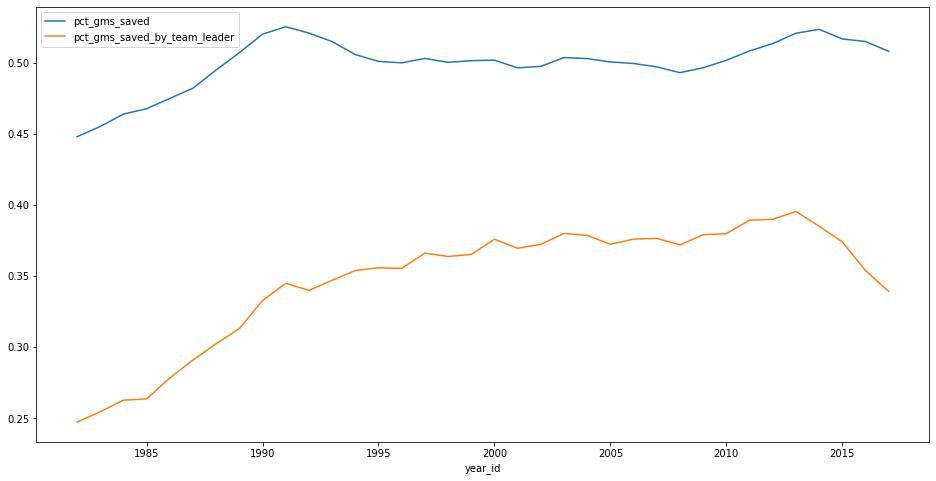

In [5]:
# OK, let's look at some overall trends

# Compute the rank for each player-season in saves
svs = df[(df['year_id']>=1980) & (df['sv']>0)][['player_id', 'year_id', 'team_id', 'sv']]
grps = svs.sort_values('sv', ascending=False).groupby('year_id')
svs['rank'] = grps.cumcount()+1

# % of all games with a save
total_saves = svs.groupby('year_id').sum()['sv']
pct_gms_saved = (total_saves/total_gms_played).dropna().rename('pct_gms_saved')

# % of all games saved by team-leading saver
leader_total_saves = svs.sort_values('sv', ascending=False).groupby(['year_id', 'team_id']).head(1).groupby('year_id').sum()['sv']
pct_gms_saved_leader =(leader_total_saves/total_gms_played).dropna().rename('pct_gms_saved_by_team_leader')

# Plot them together
pd.concat([pct_gms_saved, pct_gms_saved_leader], axis=1).rolling(5, center=True).mean().plot(figsize=FIGSIZE)

So roughly 50% of games have been saved for 30 years.

For decades, saves had been more and more concentrated with the top guy.  That trend reversed in the mid 2010s, quickly.

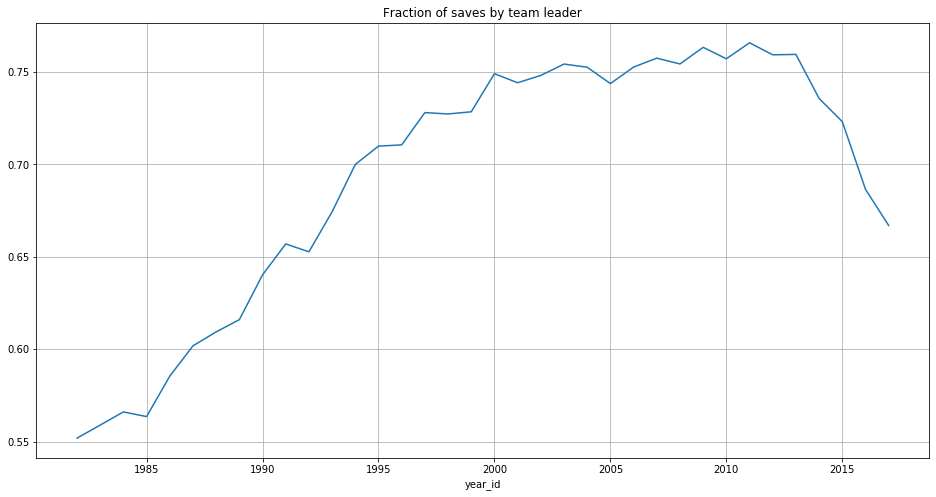

In [6]:
pct_saves_by_team_leaders = leader_total_saves/total_saves
pct_saves_by_team_leaders.rolling(5, center=True).mean().plot(figsize=FIGSIZE, grid=True, title="Fraction of saves by team leader")

This shows that trend more clearly.  In the last half-decade, 25 years of this concentration have been reversed.

In [7]:
# OK, teams on average are less frequently going to one guy.  How does this breakdown across teaams
# Eg, do some teams still employ the strategy, but there are fewer?  Or have all teams moved away

# Get team-year level saves
team_saves = svs.groupby(['team_id', 'year_id']).sum()['sv']
team_leader_saves = svs.sort_values('sv', ascending=False).groupby(['team_id', 'year_id']).head(1).set_index(['team_id', 'year_id'])['sv']
team_pct_saves_by_leader = (team_leader_saves/team_saves).rename('team_pct_saves_by_leader')

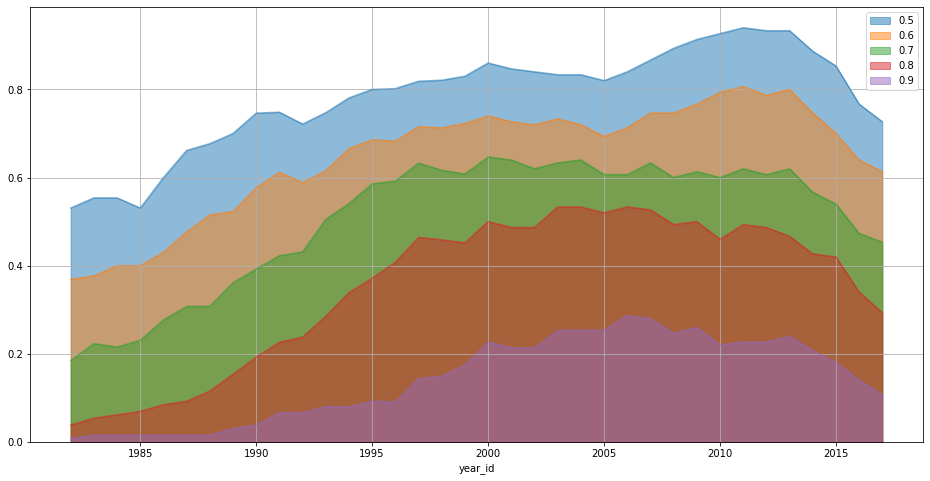

In [8]:
# The fraction of teams to reach each percentage, over time
pcts = [.5, .6, .7, .8, .9]
pd.concat([(team_pct_saves_by_leader>pct).groupby('year_id').mean().rename(pct) for pct in pcts], axis=1) \
    .rolling(5, center=True).mean().dropna() \
    .plot.area(stacked=False, grid=True, figsize=FIGSIZE)


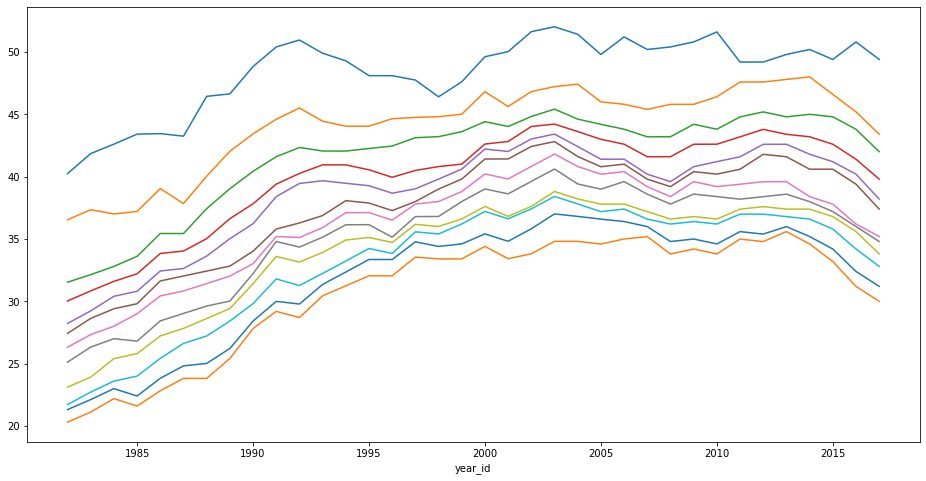

In [9]:
# OK, now look at distribution of saves more, with something of a fantasy baseball lens

# Get the total saves by the top n closers each year (top-1, top-2, etc)
svs_topn = svs[svs['rank']<=TIER_SIZE].pivot(index='year_id', columns='rank', values='sv')
svs_topn_adjusted = svs_topn.apply(lambda col: (col/avg_games_played_per_team).dropna()*162, axis=0)
svs_topn_adjusted.rolling(5, center=True).mean().plot.line(legend=None, figsize=FIGSIZE)

Rising through the early 2000s, then flat for a decade, then decling since 2013ish.  (We keep seeing this pattern, of course).  Mildly interesting is that the leading save count hasn't dropped over in the last half-decade, but the rest have.  So the trend is down, but each year somebody still gets 50ish saves.

In [10]:
# How many roster spots do you need to capture saves?  How differentiated are the tiers
# of pitchers?

# let's look by tier
svs['rank_tier'] = svs['rank'].apply(lambda rank: int(rank/TIER_SIZE)+1)
svs_by_tier = svs.groupby(['year_id', 'rank_tier']).sum()['sv']
svs_by_tier

year_id  rank_tier
1980     1            289
         2            196
         3            113
         4             85
         5             58
                     ... 
2019     14            12
         15            12
         16            12
         17            12
         18             2
Name: sv, Length: 502, dtype: int16

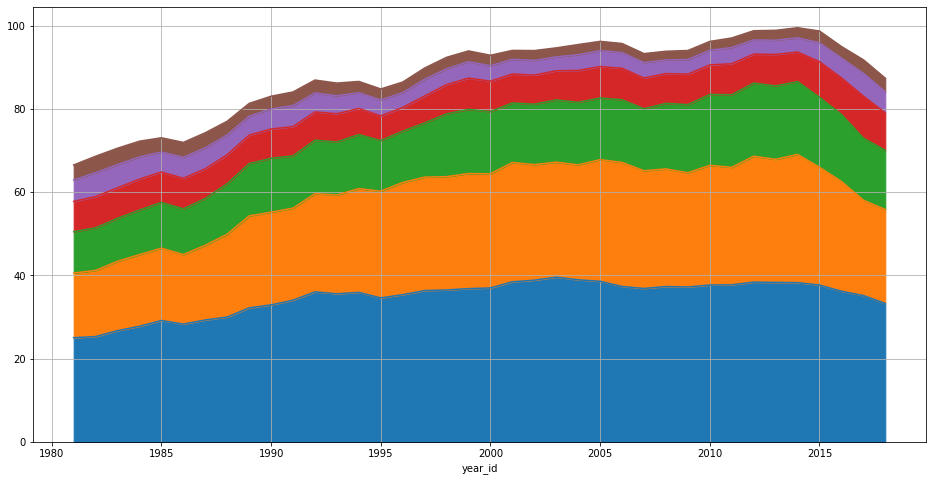

In [11]:
# Adjust for length of season, and express as saves/pitcher
svs_by_tier_adjusted = svs_by_tier/TIER_SIZE * (162/avg_games_played_per_team)

# Look at the first six tiers
svs_by_tier_adjusted.unstack()[range(1,7)].rolling(3, center=True).mean().dropna().plot.area(legend=False, grid=True, figsize=FIGSIZE)

So top-tier closers averaged nearly 40 saves from the late 90s through the mid 2010s.  The drop in the last 5ish years has been small for the first tier, big for the second tier, and appears nonexistent for the next few tiers.

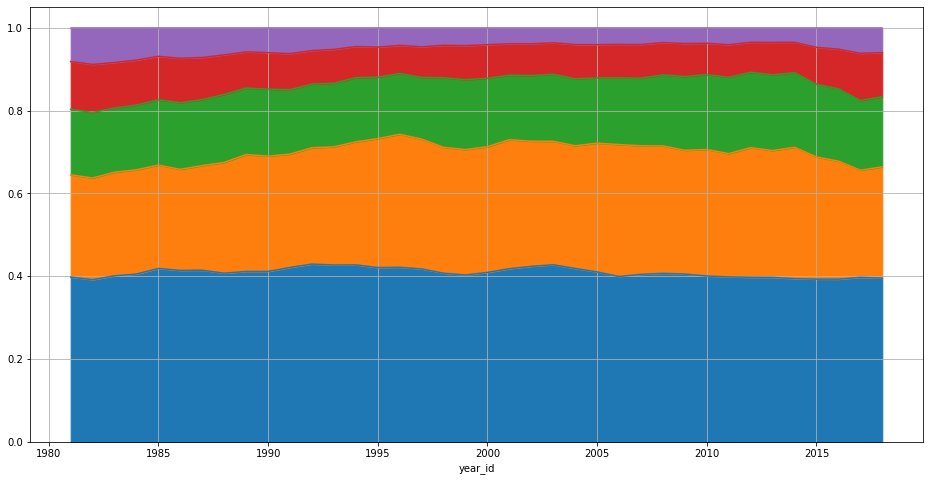

In [12]:
# OK, let's assume that only the top 5 tiers are consumed by fantasy teams, so let's discard the rest of the saves
# and see the share of each tier to that total

svs_top_tiers = svs_by_tier.unstack()[range(1,6)].apply(sum, axis=1)
pct_by_tier_scaled = svs_by_tier.unstack()[range(1,6)].apply(lambda svs_this_tier: svs_this_tier/svs_top_tiers)
pct_by_tier_scaled.rolling(3, center=True).mean().dropna().plot.area(legend=False, grid=True, figsize=FIGSIZE)